In [2]:
import numpy as np

fs = 3.2e6
threshold = .015

dir = '/home/axlan/data/'
filename = 'gqrx_20210508_054747_433900000_3200000_fc.raw'
# filename = 'gqrx_20210508_054923_433900000_3200000_fc.raw'
# filename = 'gqrx_20210508_230809_433900000_3200000_fc.raw'
# filename = 'gqrx_20210508_230857_433900000_3200000_fc.raw'
# filename = 'gqrx_20210508_230930_433900000_3200000_fc.raw'
# filename = 'gqrx_20210508_231001_433900000_3200000_fc.raw'

#fs = 1.05e6
#threshold = .1
# filename = 'n1.raw'
# filename = 'ne.raw'
# filename = 'e.raw'
# filename = 'se.raw'
# filename = 's.raw'
# filename = 'sw.raw'
# filename = 'w.raw'
# filename = 'nw.raw'
# filename = 'n2.raw'


aprox_symbol_duration = 0.0004625
aprox_symbol_samples = int(aprox_symbol_duration * fs)
single_burst = True

data = np.fromfile(dir + filename, dtype=np.csingle)
count = len(data)
mag_data = np.abs(data)



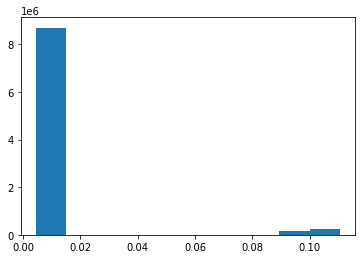

In [3]:
import matplotlib
import matplotlib.pyplot as plt

plt.hist(mag_data)
plt.show()

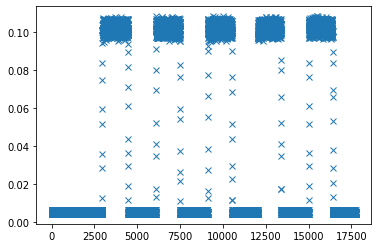

In [4]:
msg_gap = 12
gap_samples = msg_gap * aprox_symbol_samples
detect_treshold = threshold * gap_samples
gap_drop = 0.75

test_len = int(count / gap_samples) * gap_samples


if single_burst:
    msg2_start = np.argmax(mag_data > threshold)
else:
    rs = mag_data[:test_len].reshape((-1, gap_samples ))
    sums = np.sum(rs ,axis=1)


    plt.plot(sums,'x')
    plt.show()

    first_start_idx = np.argmax(sums>detect_treshold) + 1
    drop_threshold = sums[first_start_idx] * gap_drop
    drop_idx = np.argmax(sums[first_start_idx:] < drop_threshold)

    print(first_start_idx)
    print(first_start_idx + drop_idx)

    gap_idx = int((first_start_idx + drop_idx + 0.5) * gap_samples)

    msg2_start = gap_idx + np.argmax(mag_data[gap_idx:] > threshold)

plt.plot(mag_data[msg2_start-aprox_symbol_samples*2:msg2_start+aprox_symbol_samples*10],'x')
plt.show()



In [5]:
# reshape_factor = 4
# number_symbols = 256

# reshape_len = int(aprox_symbol_samples/reshape_factor)

# rs = mag_data[msg2_start:msg2_start+reshape_len*reshape_factor*256].reshape((-1,reshape_len))

# sums = np.sum(rs ,axis=1)

# plt.plot(sums,'x')
# plt.show()

# reshape_threshold = reshape_len * threshold

# leveled = sums > reshape_threshold

# plt.plot(leveled[:reshape_factor*60],'x-')
# plt.show()



In [6]:

num_bits = 128

bits = [True]

max_len = int(aprox_symbol_samples * 1.5)

threshold_data = mag_data[msg2_start:] > threshold

while len(bits) < num_bits:
    neg_index = np.argmax(threshold_data != bits[-1])
    assert(neg_index != 0)
    assert(neg_index < max_len)
    next_idx = neg_index + max_len
    if len(bits) == 9 and not threshold_data[next_idx]:
        bits = [True] + bits
    bits.append(threshold_data[next_idx])
    threshold_data = threshold_data[next_idx:]

bits = [ int(i) for i in bits ]


print(bits)


#[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0]


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1]


In [7]:
import sys  
sys.path.insert(0, '/home/axlan/src/sainlogic-sdr/gr-sainlogic/python')

from sainlogic_parser import check_crc

a = np.array(bits)
rs = a.reshape((-1, 8))
print(rs)

bytes = []
for val in rs:
    binval = ''.join([str(i) for i in val])
    bytes.append(int(binval,2))


print(bytes)
print(''.join([ f'{i:02x}' for i in bytes  ]))

print(check_crc(bytes))


# ./reveng -w 8 -s ffd4c5e000009b0012846e32fffbfb3c ffd4c5e000009a0012846e32fffbfb89
# reveng: warning: you have only given 2 samples
# reveng: warning: to reduce false positives, give 4 or more samples
# width=8  poly=0x31  init=0xff  refin=false  refout=false  xorout=0x00  check=0xf7  residue=0x00  name="CRC-8/NRSC-5"

# ./reveng -w 8 -p 31 -i ff -m CRC-8/NRSC-5 -c ffd4cf240000420000846233fffbfb
# ./reveng -m CRC-8/NRSC-5 -c ffd4cf240000420000846233fffbfb


[[1 1 1 1 1 1 1 1]
 [1 1 0 1 0 1 0 0]
 [1 1 0 0 0 1 0 1]
 [1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [1 0 0 1 1 0 1 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 1 0]
 [1 0 0 0 0 1 0 0]
 [0 1 1 0 1 1 1 0]
 [0 0 1 1 0 0 1 0]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 0 1 1]
 [1 1 1 1 1 0 1 1]
 [1 0 0 0 1 0 0 1]]
[255, 212, 197, 224, 0, 0, 154, 0, 18, 132, 110, 50, 255, 251, 251, 137]
ffd4c5e000009a0012846e32fffbfb89
True


In [8]:
with open(f'../out/{filename}.bin' ,'wb') as fd:
    fd.write(bytearray(bytes))